# Summary of work

This notebook shows how various classes behave when embedded in UMAP or PaCMAP, and the effect of using a cosine or Euclidean distance metric. It also explores the effect of downsampling, both before and after embedding the spec2vec vectors. At some point of research, downsampling data "revealed" very interesting topology, but this was actually a bug as explained in the last chapter. The notebook also shows evidence that UMAP can work with separate seen and "unseen" data, and provides minimal working examples for plotting static UMAPs with seaborn and interactive UMAPs with plotly.express. 

# Import libraries, functions, and data

In [334]:
import pickle
import itertools
import numpy as np
import pandas as pd
import umap
import pacmap

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


def colour_dict(var_column, blackout_list=[]):
    # Creates a colour dictionary with 20 distinct colours. Blackout_list offers the possibility to directly assign the colour black to groups.  
    # If the number of groups in the variable column exceeds 20, the only largest groups will be given the distinct colours.
    # If the number of groups is smaller than 20, the first n colours will be used.
    # Colours by Sasha Trubetskoy at https://sashamaps.net/docs/resources/20-colors/
    
    colours = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#0000CD', '#800000', # replaced FFFAC8 (beige) with #0000CD (medium blue) for better visibility against white background
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080']
    groups = list(var_column.value_counts(ascending=False).index)
    for elem in blackout_list:
        groups.remove(elem)
    while (len(groups) > len(colours)):
           colours.append("#000000")
    colour_dict = dict(zip(groups, colours))
    for elem in blackout_list:
        colour_dict[elem] = "#000000"
    return colour_dict


def undersample_classes(spectrum_metadata, var, min_class_size, sample_size, random_state = 42):
    # Pass spectrum_metadata dataframe to function, and it will return a downsampled selection for you, from classes that satisfy the specified minimum class size
    # Multiclass spectra are automatically detected and ignored
    # If sample_size input is an integer, this will be the sample size.
    # If sample_size == "all" or any other non-integer, all spectra from the classes that satisfy the minimum class size will be be returned
    
    class_counts = spectrum_metadata[var].value_counts()
    class_counts = class_counts[class_counts>=min_class_size]
    selected_classes = class_counts[[';' not in s for s in class_counts.index]] # Discard multiclass labels
    selection = spectrum_metadata[spectrum_metadata[var].isin(selected_classes.index)]
    
    if (isinstance(sample_size, int)):
        class_dict = dict(selected_classes)
        class_dict = dict.fromkeys(class_dict, sample_size)
        resampler = RandomUnderSampler(sampling_strategy = class_dict, random_state = random_state)
        downsampled_selection = resampler.fit_resample(selection, selection[var])[0]
        metadata_indices = selection.iloc[resampler.sample_indices_].index # Get original indices by taking the sampled rows from the selection dataframe
        downsampled_selection.set_index(metadata_indices, inplace = True)  # Restore original indices
        return downsampled_selection
    return selection

In [469]:
data_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Data/"
plot_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Plots/"

# Load precalculated spec2vec vectors
spectrum_vectors = pd.read_csv(data_dir+"ALL_GNPS_210409_positive_spectrumvectors_weighted_0.5.csv", sep = "\t", header = None)
spectrum_metadata = pd.read_csv(data_dir+"GNPS_210409 Metadata inchi annotated spectra.csv", sep = "\t")

len(spectrum_vectors) == len(spectrum_metadata)

True

# Define models
For the models, I choose 50 neighbors which is on the smaller side of things, but speeds up the embedding process considerably compared to 200 neighbors. Meanwhile,the improvements typically yielded by using 200 neighbours are only modest. I set min_dist at a mid-high value to combat overplotting in the more dense plots while still accommodating clustering with smaller datasets. I fixed the random_state for the UMAPs to make fair comparisons between the downsampled data plots, and the plots with all data. PaCMAP also supports setting a random_state as of 0.5.0 (current version), but using it causes highly unusual and unusable results so I did not use it. Note that by setting n_neighbors to None, you allow the model to use an adaptive default value that scales with the size of the dataset, which I recommend. PaCMAP also has a "distance" parameter, but this parameter does not know cosine distance as of yet.

In [625]:
cosine_umap = umap.UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.75, metric = "cosine", random_state = 42)
euclidean_umap = umap.UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.75, metric = "euclidean", random_state = 42)
default_pacmap = pacmap.PaCMAP(n_dims=2, n_neighbors = None) 

# Examples of plotting code

For this project I have done a lot of plotting, most of which in 2D, but some of which also in 3D. Here I share some minimal working examples of how I select my data, process it, and visualize it. A nice feature of saving plotly figures as HTML, is that they remain interactive when shared.

## Create UMAPs
Two often discussed UMAP parameters are min_dist and spread, which can be more directly controlled using a and b. It's important to know that these parameters are only cosmetic: they can increase or decrease the gap between clusters, but they can't create a separation between two classes that are not already separated by a given value of n_neighbors. 
As such, n_neighbors is the most important variable, followed by metric. For n_neighbors, I prefer values of at least 50, which I've used as the default in this notebook. The cosine distance metric often does a better job of spreading out the spectra as the Euclidean distance between spec2vec vectors appears to be minimal.

In [50]:
%%time
var = "npc_pathway_results"
selection = spectrum_metadata[spectrum_metadata[var].notna()] # Remove all spectra that have not been assigned an NPC pathway
x = spectrum_vectors.iloc[selection.index]
y = selection[var]

umap_2d = umap.UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.75, metric = "cosine").fit_transform(x)
umap_3d = umap.UMAP(n_components = 3, n_neighbors = 50, min_dist = 0.75, metric = "cosine").fit_transform(x)

Wall time: 6min 6s


In [51]:
# For a single set of UMAP coordinates, I prefer to bundle UMAP coordinates and labels together in pandas Dataframes
umap_2d_y = pd.DataFrame(umap_2d, columns = ["x", "y"], index = y)
umap_3d_y = pd.DataFrame(umap_3d, columns = ["x", "y", "z"], index = y)
umap_3d_y[0:10]

x         y          z
npc_pathway_results                                                  
Amino acids and Peptides               11.006533 -0.935247  15.031392
Amino acids and Peptides               11.149221 -0.706329  15.032350
Amino acids and Peptides                9.423556 -2.671339  13.041025
Shikimates and Phenylpropanoids        11.569158 -2.515679  14.448630
Amino acids and Peptides; Polyketides  12.684282 -1.014071   9.197035
Amino acids and Peptides; Polyketides  11.363641  0.516010  12.955448
Amino acids and Peptides                9.872707 -2.837335  10.245778
Amino acids and Peptides; Polyketides  11.631846 -1.755197  12.618655
Amino acids and Peptides               10.857827  0.901727  12.645243
Amino acids and Peptides; Polyketides  11.475653 -1.516997  14.209846

## 2D example seaborn

In [ ]:
plot_df = umap_2d_y
plt.figure(figsize = (16,10))
plot = sns.scatterplot(x = plot_df["x"], y = plot_df["y"], hue = plot_df.index, palette = colour_dict(pd.Series(plot_df.index)), s = 1)
plot.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), ncol=1)
plt.title("2D UMAP of NPC pathways, n_neighbors = 50, metric = cosine")

## 2D example plotly.express
Using the legend on the right, you can "turn off" the display of certain classes. By double-clicking a class, you turn off everything _except_ that class. You can zoom in using click-and-drag, and zoom out by double-clicking. Marker size, however, does not scale with zooming in, the zoom function does have some limitations.

In [ ]:
plot_data = umap_2d_y
fig = px.scatter(plot_data, x = "x", y = "y", color = plot_data.index, color_discrete_map = colour_dict(pd.Series(plot_data.index)), title = "2D UMAP of NPC pathways, n_neighbors = 50, metric = cosine")
fig.update_traces(marker={'size': 1})
fig.update_layout(width=1400, height=700,legend= {'itemsizing': 'constant'})

## 3D example plotly.express

In [ ]:
plot_data = umap_3d_y
fig = px.scatter_3d(plot_data, x="x", y="y", z="z", color=plot_data.index, color_discrete_map = colour_dict(pd.Series(plot_data.index)), title = "3D UMAP of NPC pathways, n_neighbors = 50, metric = cosine")
fig.update_traces(marker={'size': 0.7})
fig.update_layout(width=1400, height=700, legend= {'itemsizing': 'constant'})

#fig.write_html(plot_dir+"3D cosine-based UMAP of NPC superclass - 3000 spectra per class.html")

# Is UMAP's transform function reliable?

UMAP offers the possibility to train a UMAP model on one set of data, and transform unseen data using the same model. This is an enticing feature, but it's only as useful as it is accurate. Here we select all NPC Pathway classes larger than 3000 spectra, and create a stratified train/test split, with 10% reserved for testing. We fit a UMAP model with the training set, and use this model to embed the test set separately. Comparing the training and test plots, the test plot appears faithful to the training data. The large blue clusters are there, and the "dashing" blue islands in the lower left can also be identified with ease. The red/multicolor cloud is smaller in the test set, but the bit of blue at -3,10 appears preserved.

In [596]:
var = "npc_pathway_results"
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
x = spectrum_vectors.iloc[selection.index]
y = selection[var]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, stratify = y)

In [597]:
fit_model = cosine_umap.fit(X_train)
test_embedding = fit_model.transform(X_test)

In [598]:
test_df = pd.DataFrame(test_embedding, index = y_test, columns = ["x", "y"])
train_df = pd.DataFrame(fit_model.embedding_, index = y_train, columns = ["x", "y"])

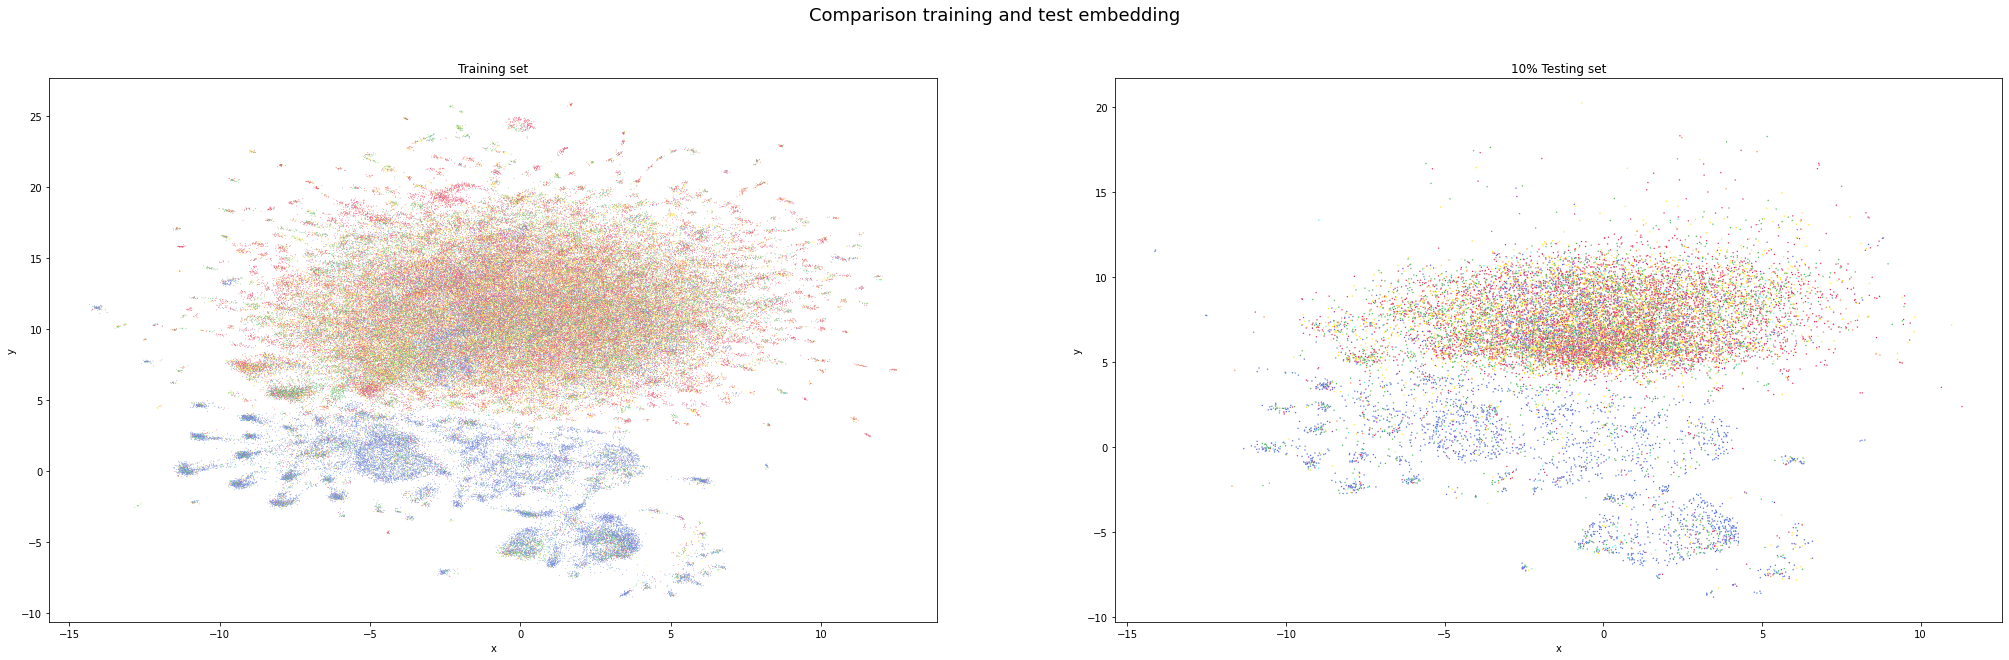

In [601]:
palette = colour_dict(y)

fig, axes = plt.subplots(1, 2, figsize=(35,10))
fig.suptitle("Comparison training and test embedding", fontsize = 18)
titles = ["Training set", "10% Testing set"]

sns.scatterplot(x = train_df["x"], y = train_df["y"], hue = train_df.index, s = 0.5, legend = False, palette = palette, ax = axes[0])
sns.scatterplot(x = test_df["x"], y = test_df["y"], hue = test_df.index, s = 2, legend = False, palette = palette, ax = axes[1])

for ax, title in zip(axes, titles):
    ax.set_title(title)

# NPC Pathway UMAPs

In [627]:
var = "npc_pathway_results"

# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
npc_pathway_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
npc_pathway_x_all = spectrum_vectors.iloc[selection.index]

In [ ]:
%%time
x = [npc_pathway_x, npc_pathway_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished complete set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
npc_pathway_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

In [516]:
with open(data_dir+"npc_pathway_umap.pickle", 'wb') as f:
        pickle.dump(npc_pathway_dfs, f)

In [517]:
with open(data_dir+"npc_pathway_umap.pickle", "rb") as f:
    npc_pathway_dfs = pickle.load(f)

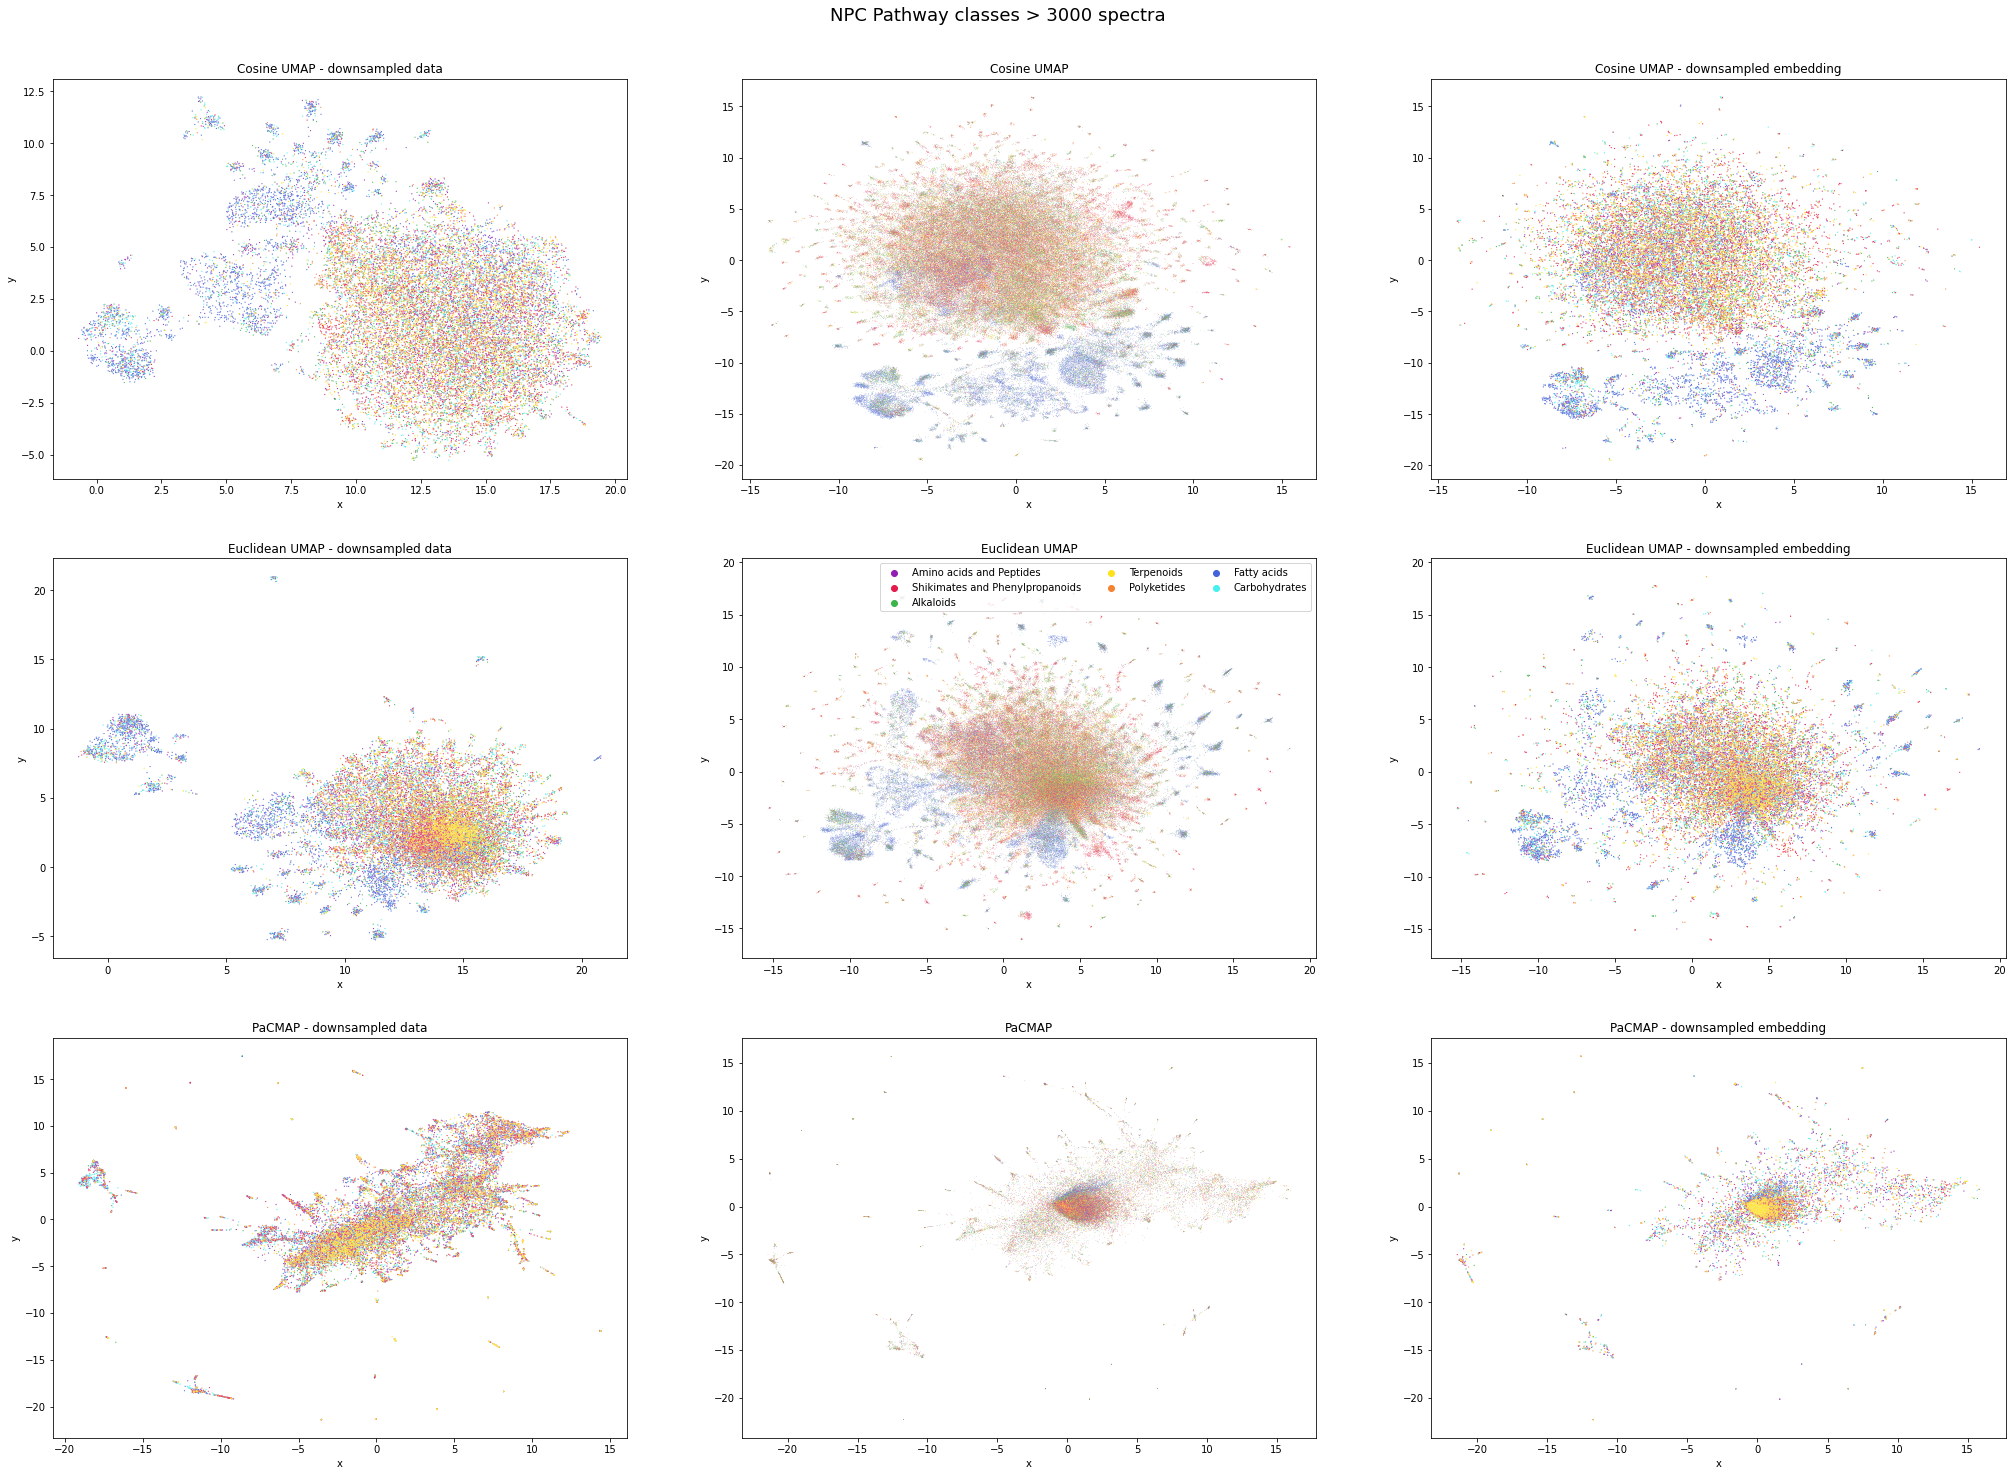

In [632]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = npc_pathway_dfs
var = "npc_pathway_results"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1.5, 0.2, 1.5]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("NPC Pathway classes > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3)

fig.savefig(plot_dir+"NPC pathway UMAP summary.jpg")

# NPC Superclass UMAPs

In [602]:
var = "npc_superclass_results"

# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
npc_superclass_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
npc_superclass_x_all = spectrum_vectors.iloc[selection.index]

In [603]:
%%time
x = [npc_superclass_x, npc_superclass_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished downsampled UMAP set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
npc_superclass_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

Finished downsampled set


C:\Users\Artur\anaconda3\envs\plotly\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Finished downsampled UMAP set
Wall time: 9min 13s


In [604]:
with open(data_dir+"npc_superclass_umap.pickle", 'wb') as f:
        pickle.dump(npc_superclass_dfs, f)

In [605]:
with open(data_dir+"npc_superclass_umap.pickle", "rb") as f:
    npc_superclass_dfs = pickle.load(f)

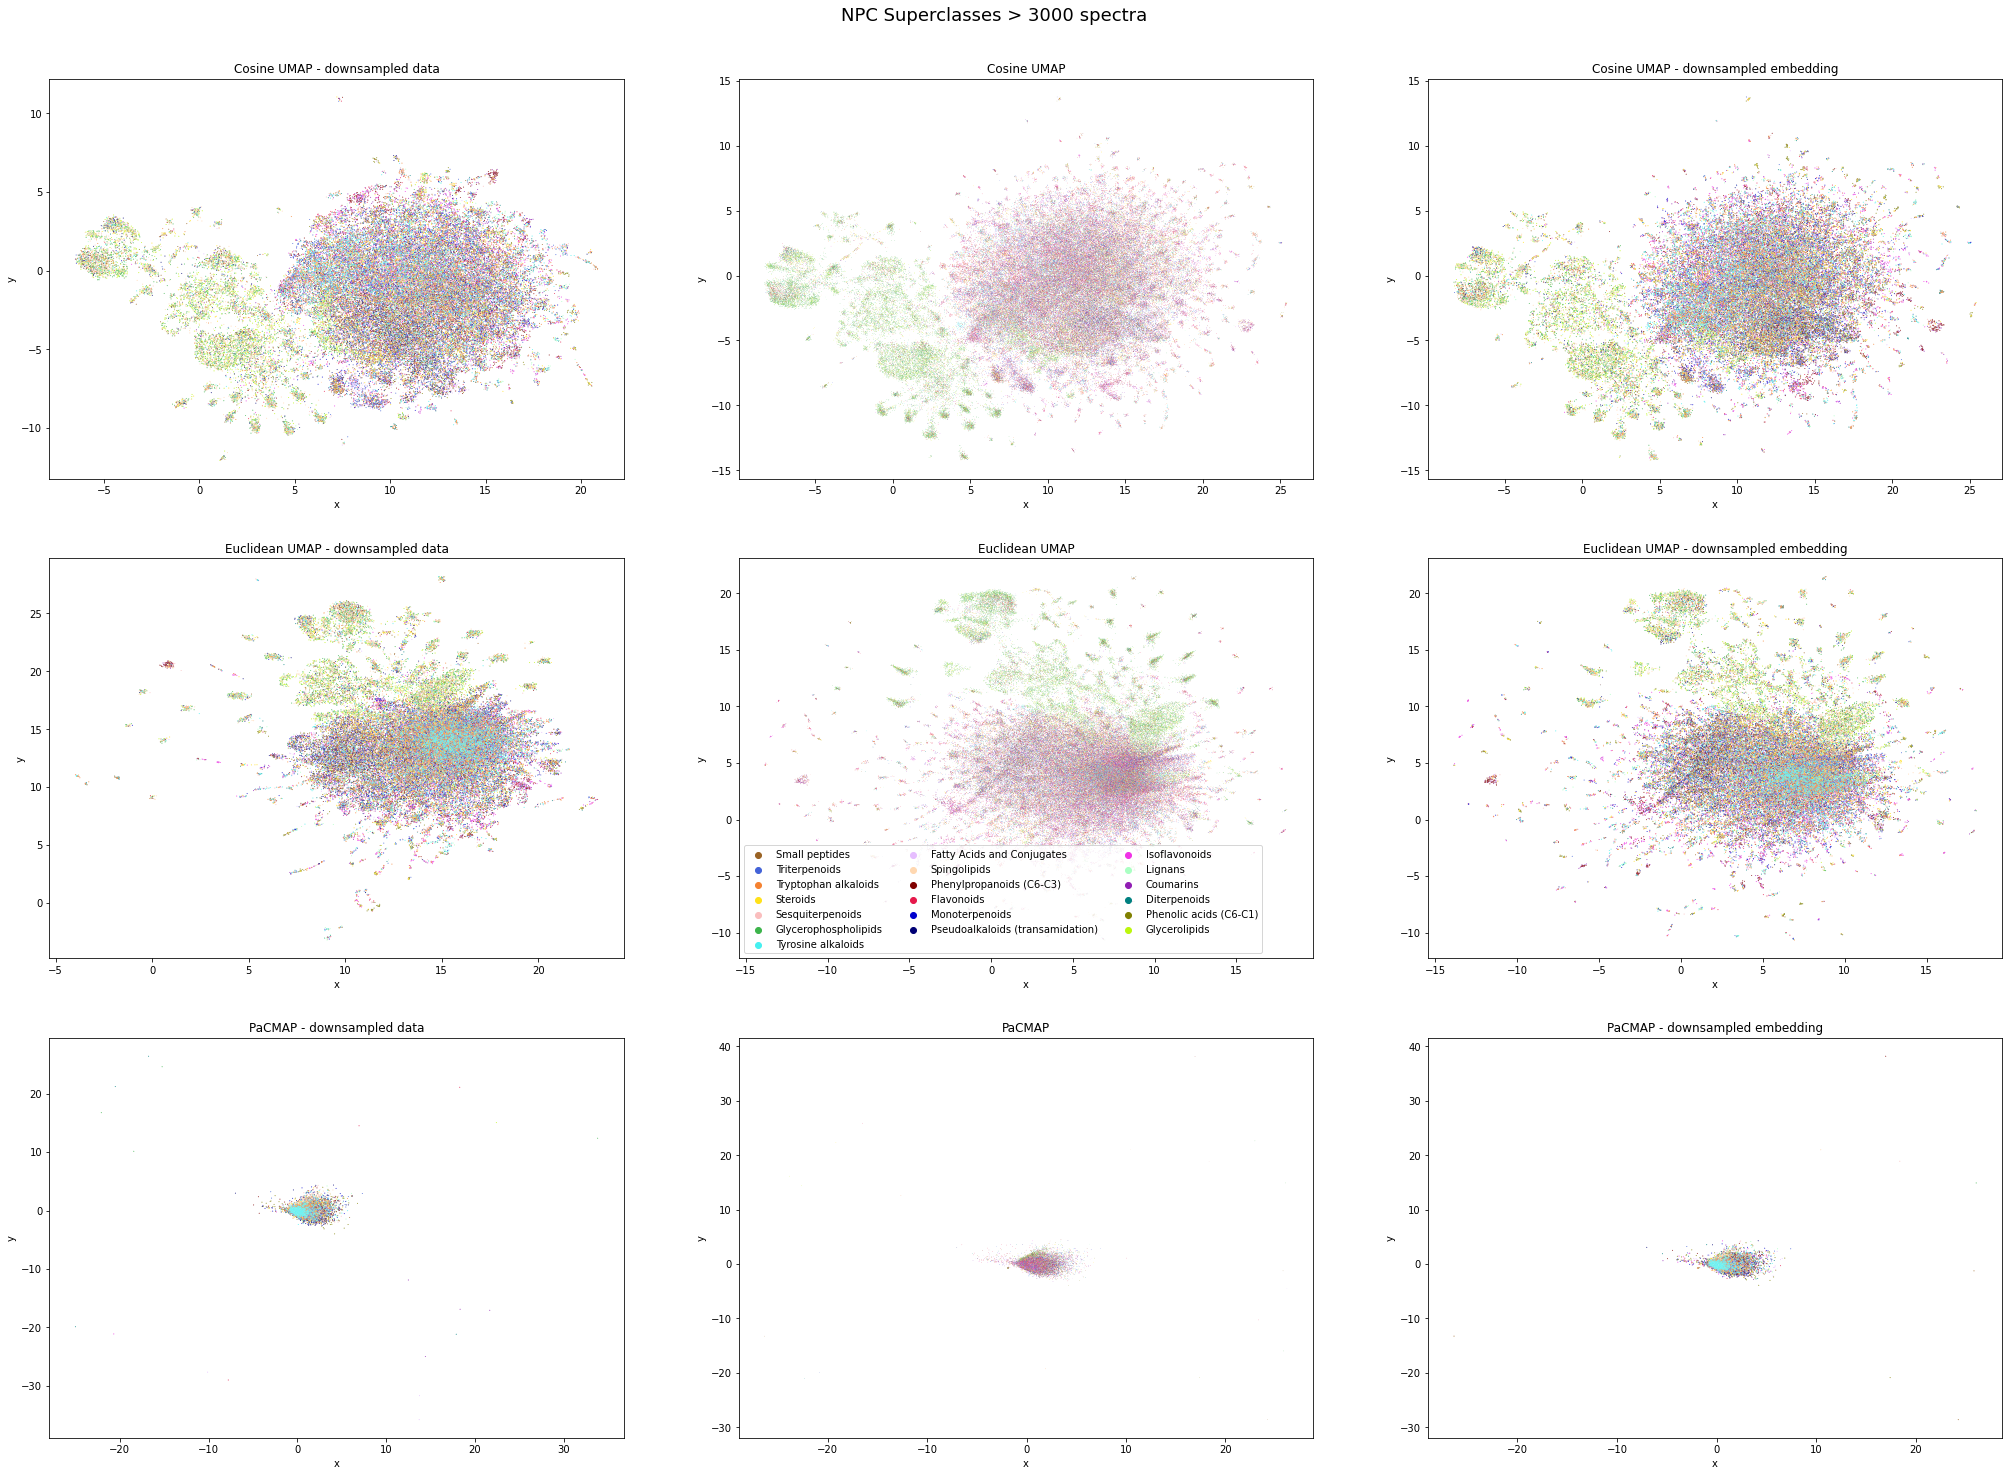

In [633]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = npc_superclass_dfs
var = "npc_superclass_results"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1, 0.2, 1]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("NPC Superclasses > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3)

fig.savefig(plot_dir+"NPC superclass UMAP summary.jpg")

# CF Superclass UMAPs

In [467]:
var = "cf_superclass"
spectrum_metadata[var].value_counts()

Lipids and lipid-like molecules              56916
Phenylpropanoids and polyketides             41958
Organoheterocyclic compounds                 22425
Benzenoids                                   18049
Organic acids and derivatives                11631
Alkaloids and derivatives                     9007
Organic oxygen compounds                      8693
Lignans, neolignans and related compounds     2539
Nucleosides, nucleotides, and analogues       1920
Organic nitrogen compounds                    1409
Hydrocarbons                                   317
Organosulfur compounds                         235
Hydrocarbon derivatives                        219
Organic Polymers                                81
Organophosphorus compounds                      42
Organometallic compounds                        33
Organohalogen compounds                         25
Organic 1,3-dipolar compounds                   13
Homogeneous non-metal compounds                  9
Name: cf_superclass, dtype: int

In [468]:
# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
cf_superclass_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
cf_superclass_x_all = spectrum_vectors.iloc[selection.index]

In [470]:
%%time
x = [cf_superclass_x, cf_superclass_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished complete set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
cf_superclass_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

Finished downsampled set


C:\Users\Artur\anaconda3\envs\plotly\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Finished downsampled UMAP set
Wall time: 17min 42s


In [471]:
with open(data_dir+"cf_superclass_umap.pickle", 'wb') as f:
        pickle.dump(cf_superclass_dfs, f)

In [472]:
with open(data_dir+"cf_superclass_umap.pickle", "rb") as f:
    cf_superclass_dfs = pickle.load(f)

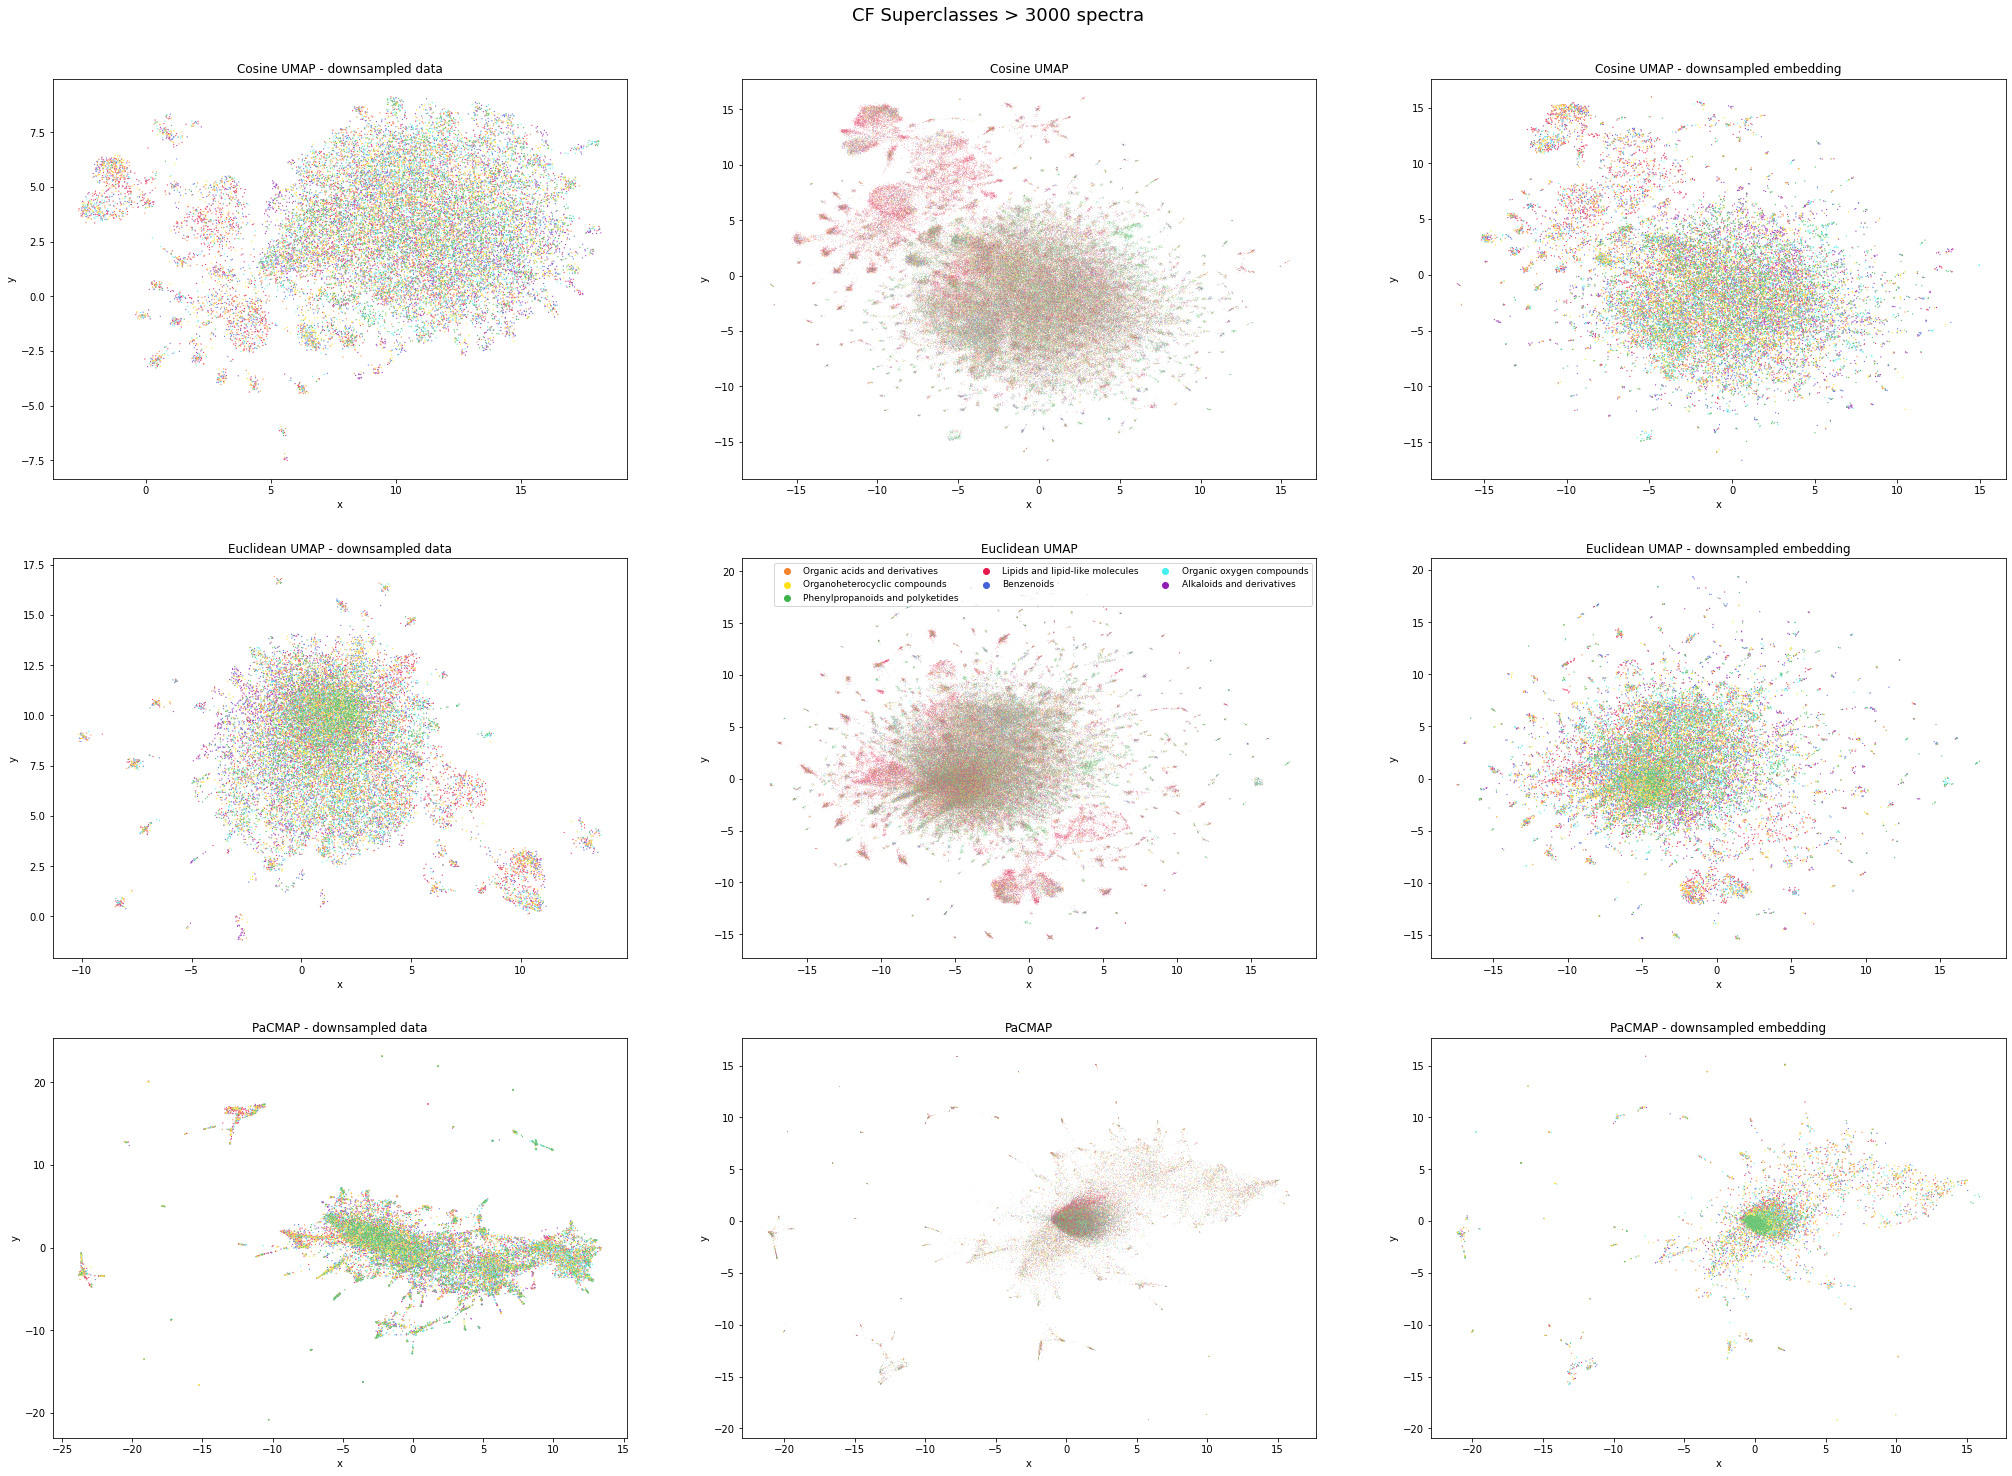

In [634]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = cf_superclass_dfs
var = "cf_superclass"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1.5, 0.2, 1.5]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("CF Superclasses > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3, fontsize = 9) # The classes of this figure have longer names. I shrank the fontsize from 10 to 9 so the legend will fit within the plot.

fig.savefig(plot_dir+"CF superclass UMAP summary.jpg")

# CF class UMAPs

In [579]:
var = "cf_class"
spectrum_metadata[var].value_counts()

Prenol lipids                          23618
Flavonoids                             19482
Glycerophospholipids                   12517
Benzene and substituted derivatives    12358
Steroids and steroid derivatives        9580
                                       ...  
Cyclobutane lignans                        1
Pavine alkaloids                           1
Thienodiazepines                           1
Imidazodiazepines                          1
Other non-metal organides                  1
Name: cf_class, Length: 278, dtype: int64

In [580]:
# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
cf_class_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
cf_class_x_all = spectrum_vectors.iloc[selection.index]

In [581]:
%%time
x = [cf_class_x, cf_class_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished complete set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
cf_class_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

Finished downsampled set
Finished complete set
Wall time: 7min 10s


In [582]:
with open(data_dir+"cf_class_umap.pickle", 'wb') as f:
        pickle.dump(cf_class_dfs, f)

In [583]:
with open(data_dir+"cf_class_umap.pickle", "rb") as f:
    npc_class_dfs = pickle.load(f)

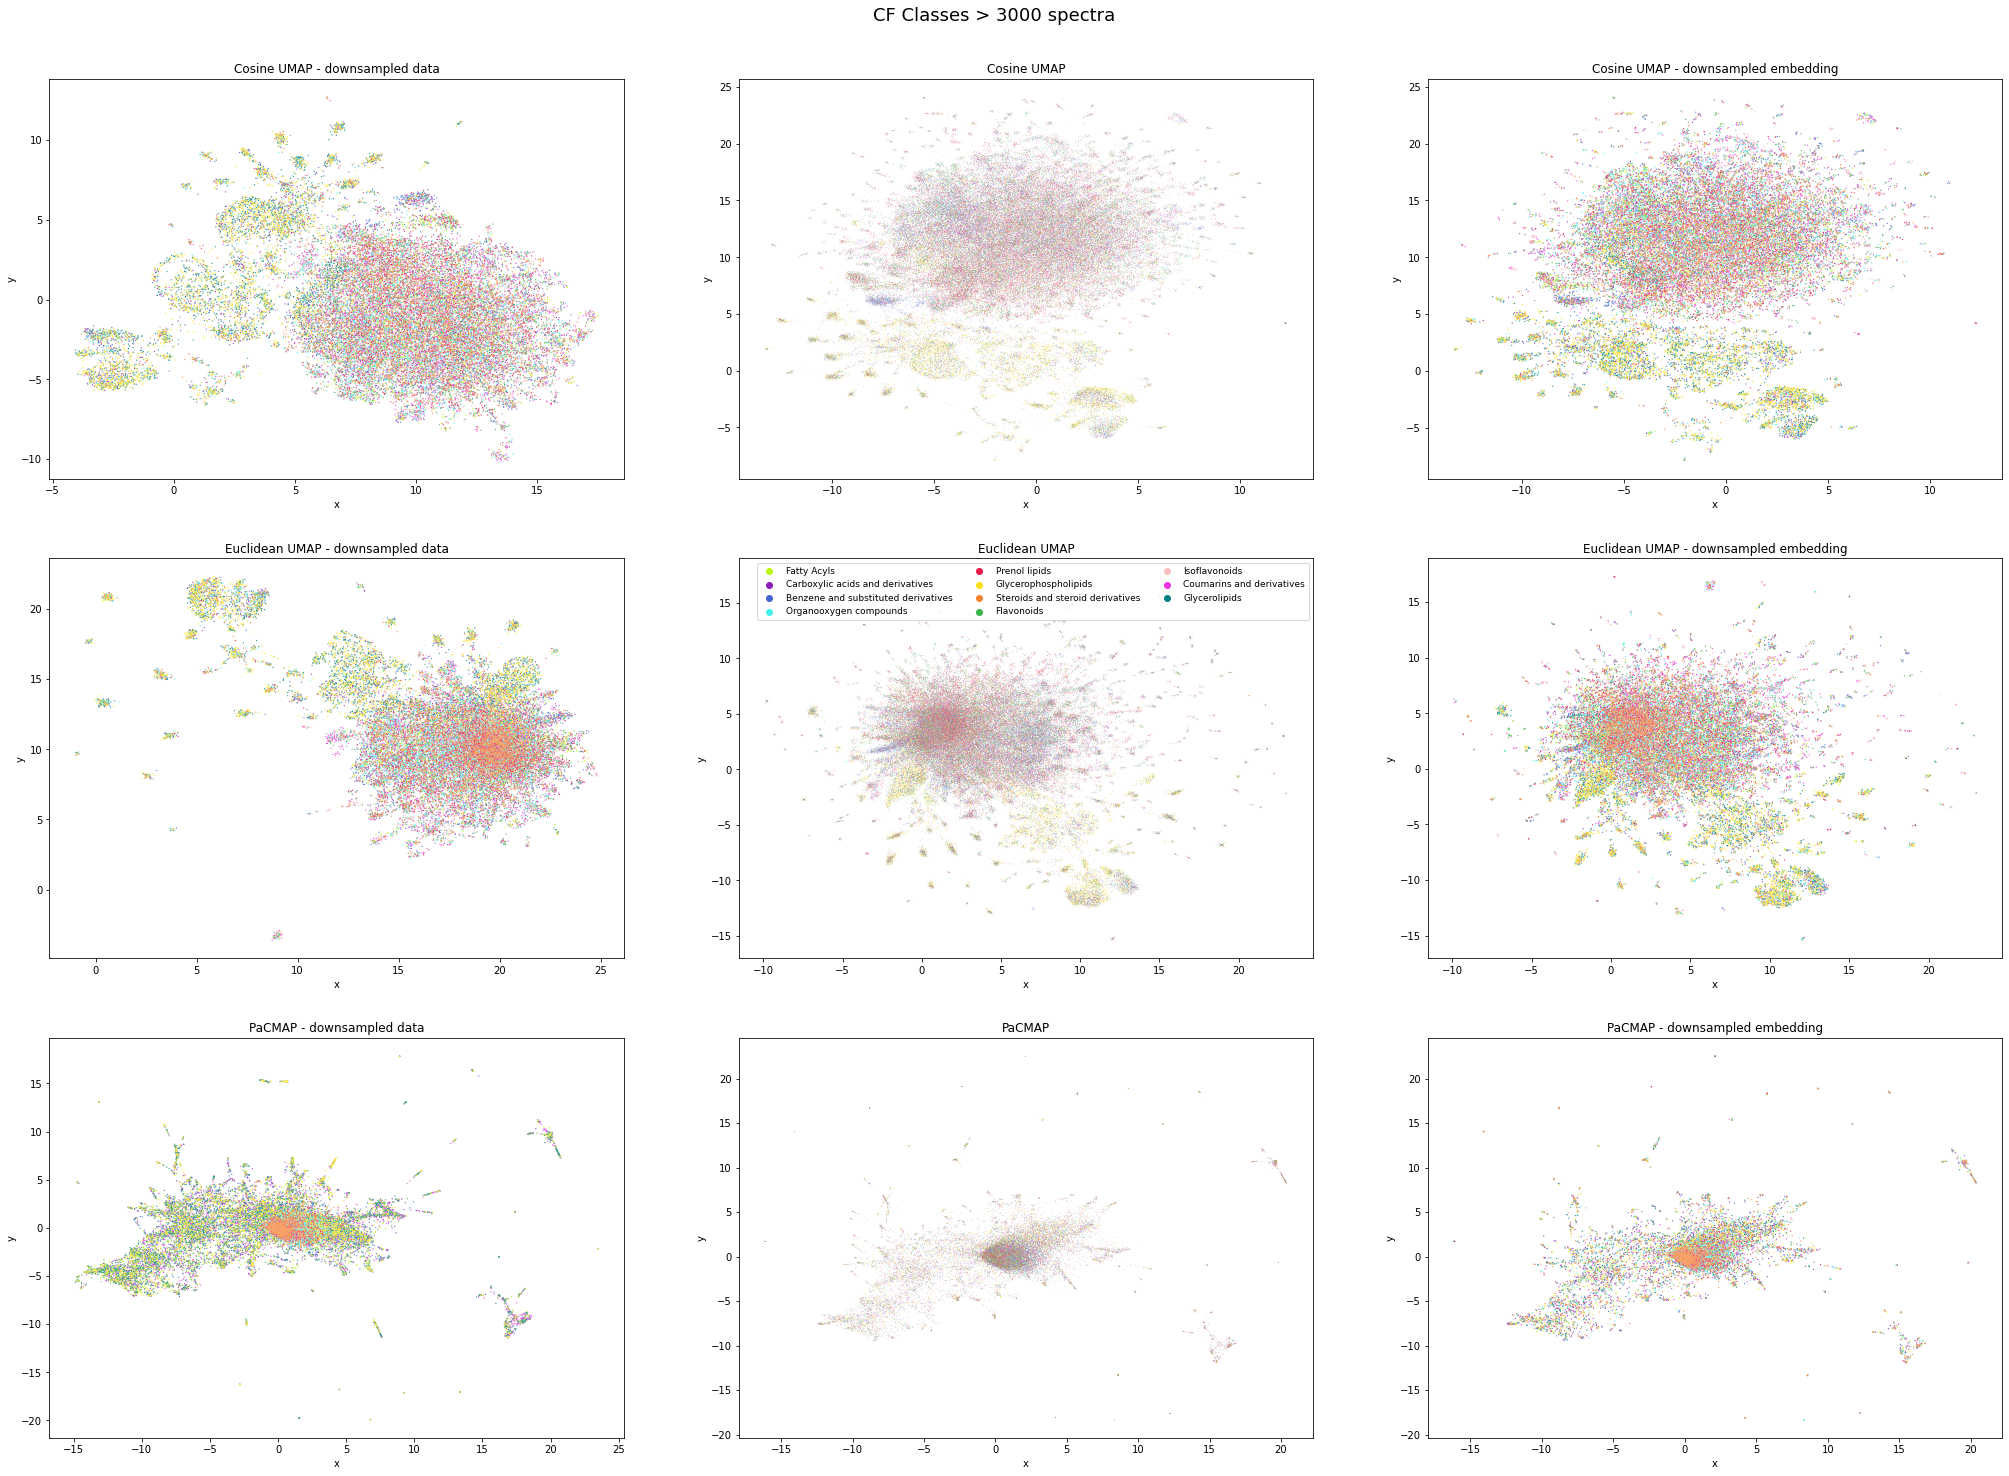

In [635]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = cf_class_dfs
var = "cf_class"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1.5, 0.2, 1.5]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("CF Classes > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3, fontsize = 9) # The classes of this figure have longer names. I shrank the fontsize from 10 to 9 so the legend will fit within the plot.

fig.savefig(plot_dir+"CF class UMAP summary.jpg")

# Why do the downsampled data plots look different than in the presentation from 21-10-2021?

In the undersample_classes function, I use imbalanced-learn's RandomUnderSampler. I was under the false assumption that RandomUnderSampler returned my dataframe with the indices intact, but instead RandomUnderSampler resets the indices. Because I use the indices to select the corresponding spec2vec vectors, the plots are a result of the first x vectors, combined with the classifications of the spectra selected by the RandomUnderSampler. This combination, however exciting the resulting plot, holds no meaning whatsoever.

I've recreated the mistake (and corresponding plot for NPC Pathways) below.

In [542]:
var = "npc_pathway_results"

# Select all classes > 3000 spectra to make the same colour dictionary as in the presentation
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
palette = colour_dict(selection[var])

# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
y = selection[var]

# Just select first x vectors, same length as y
x = spectrum_vectors.iloc[0:len(y)]

# Create UMAP and dataframe
coords = umap.UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.75, metric = "cosine").fit_transform(x)
df = pd.DataFrame(coords, columns = ["x", "y"], index = y)

<AxesSubplot:xlabel='x', ylabel='y'>

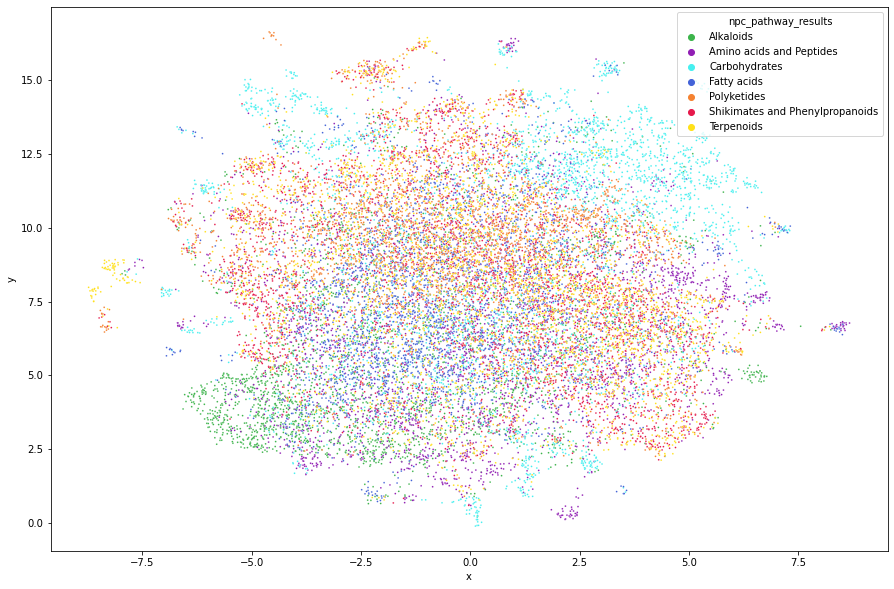

In [544]:
# Plot results
plt.figure(figsize=(15,10))
sns.scatterplot(x=df["x"], y=df["y"], hue = df.index, s = 3, palette = palette)

## Code from undersample_classes function

In [545]:
var = "npc_pathway_results"; min_class_size = 3000; sample_size = 3000

class_counts = spectrum_metadata[var].value_counts()
class_counts = class_counts[class_counts>=min_class_size]
selected_classes = class_counts[[';' not in s for s in class_counts.index]] # Discard multiclass labels
selection = spectrum_metadata[spectrum_metadata[var].isin(selected_classes.index)]
    
if (isinstance(sample_size, int)):
    class_dict = dict(selected_classes)
    class_dict = dict.fromkeys(class_dict, sample_size)
    resampler = RandomUnderSampler(sampling_strategy = class_dict, random_state = random_state)
    downsampled_selection = resampler.fit_resample(selection, selection[var])[0]
    metadata_indices = selection.iloc[resampler.sample_indices_].index # Get original indices by taking the sampled rows from the selection dataframe
    #downsampled_selection.set_index(metadata_indices, inplace = True)  # Restore original indices

In [546]:
# RandomUnderSampler gives output with reset indices
downsampled_selection

ID                     inchikey  \
0      CCMSLIB00004717392  PSFDQSOCUJVVGF-UHFFFAOYSA-N   
1      CCMSLIB00006096998  MXYUKLILVYORSK-HBMCJLEFSA-N   
2      CCMSLIB00005932351  DGQPIOQRPAGNGB-BJKJVOPESA-N   
3      CCMSLIB00006088201  DZKBRKKSFHBYIN-BHHLKMBKSA-N   
4      CCMSLIB00005885192  POJWUDADGALRAB-UHFFFAOYSA-N   
...                   ...                          ...   
20995  CCMSLIB00004703218  HHDWDLBSGSYIQQ-GNDDPXJISA-N   
20996  CCMSLIB00005465674  DKPMWHFRUGMUKF-HJNWHKLXSA-N   
20997  CCMSLIB00005727721  SJCPVUVBUQDGKN-VXWIUBPCSA-N   
20998  CCMSLIB00005978201  MONAOJUXJOXWQB-SGDDSLAFSA-N   
20999  CCMSLIB00000854138  YFTXKZMMMCWVPM-UHFFFAOYSA-N   

                                                   inchi  \
0      InChI=1S/C12H10N2/c1-8-12-10(6-7-13-8)9-4-2-3-...   
1      InChI=1S/C22H27NO2/c1-23-19(15-21(24)17-9-4-2-...   
2      InChI=1S/C17H17NO5/c1-18-3-2-8-4-11(19)16-14(1...   
3      InChI=1S/C34H38N2O6/c1-35-24-14-19(15-25(35)29...   
4      InChI=1S/C4H6N4O3/c5-3(10)6-1-2(9)8-4(11)7-1/h...   
...                                                  ...   
20995  InChI=1S/C17H26O12/c1-17(25)8-7(10(20)13(17)23...   
20996  InChI=1S/C24H40O5/c1-13(4-7-19(26)27)15-5-6-16...   
20997  InChI=1S/C29H34O10/c1-16-7-9-26-14-34-23(32)22...   
20998  InChI=1S/C46H58O8/c1-27(2)28-18-23-46(26-53-40...   
20999  InChI=1S/C66H106O32/c1-24-34(70)38(74)44(80)54...   

                     instrument  spectrum_index  \
0                       ESI-QFT          111930   
1                      Orbitrap          187878   
2                      Orbitrap          139968   
3                      Orbitrap          180039   
4                      Orbitrap          117493   
...                         ...             ...   
20995                   ESI-QFT          101144   
20996                      qTof           30904   
20997                 Hybrid FT           70065   
20998                  Orbitrap          156196   
20999  Maxis II HD Q-TOF Bruker           18042   

                                                  smiles         cf_kingdom  \
0                             CC1=NC=CC2=C1NC3=CC=CC=C23  Organic compounds   
1      CN1[C@@H](CCC[C@@H]1CC(=O)C2=CC=CC=C2)C[C@@H](...  Organic compounds   
2             O=C1OC2C(O)C=C3CCN(C)C3C2C4=CC=5OCOC5C=C14  Organic compounds   
3      O=C(OC1CC2N(C)C(C1)C3OC32)C4C=5C=CC=CC5C(C(=O)...  Organic compounds   
4                                 O=C(N)NC(C(N1)=O)NC1=O  Organic compounds   
...                                                  ...                ...   
20995  COC(=O)C/1=C/O[C@@H](O[C@@H]2O[C@H](CO)[C@@H](...  Organic compounds   
20996  C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@]3([H])[C@H](...  Organic compounds   
20997  CC1=CC2C3(CC1)COC(=O)C4C5(O4)CCOC(C5O)(/C=C\C=...  Organic compounds   
20998  O=C(O)C=1C=CC=CC1C(=O)OCC23CCC(C(=C)C)C3C4CCC5...  Organic compounds   
20999  CC1OC(OC2C(C)OC(OC3C(O)C(O)C(CO)OC3OC(=O)C45CC...  Organic compounds   

                         cf_superclass                          cf_class  \
0            Alkaloids and derivatives                 Harmala alkaloids   
1             Organic oxygen compounds            Organooxygen compounds   
2            Alkaloids and derivatives          Amaryllidaceae alkaloids   
3                           Benzenoids                      Naphthalenes   
4         Organoheterocyclic compounds                            Azoles   
...                                ...                               ...   
20995  Lipids and lipid-like molecules                     Prenol lipids   
20996  Lipids and lipid-like molecules  Steroids and steroid derivatives   
20997  Lipids and lipid-like molecules                     Prenol lipids   
20998  Lipids and lipid-like molecules                     Prenol lipids   
20999  Lipids and lipid-like molecules                     Prenol lipids   

                                       cf_subclass  \
0                                              NaN   
1                     

In [549]:
# The same spectrum metadata can be collected by retrieving the resampler's sample_indices_ and applying them to the selection dataframe
spectrum_metadata.iloc[selection.iloc[resampler.sample_indices_].index]

ID                     inchikey  \
99737   CCMSLIB00004717392  PSFDQSOCUJVVGF-UHFFFAOYSA-N   
175250  CCMSLIB00006096998  MXYUKLILVYORSK-HBMCJLEFSA-N   
127340  CCMSLIB00005932351  DGQPIOQRPAGNGB-BJKJVOPESA-N   
167411  CCMSLIB00006088201  DZKBRKKSFHBYIN-BHHLKMBKSA-N   
104865  CCMSLIB00005885192  POJWUDADGALRAB-UHFFFAOYSA-N   
...                    ...                          ...   
88951   CCMSLIB00004703218  HHDWDLBSGSYIQQ-GNDDPXJISA-N   
28521   CCMSLIB00005465674  DKPMWHFRUGMUKF-HJNWHKLXSA-N   
57959   CCMSLIB00005727721  SJCPVUVBUQDGKN-VXWIUBPCSA-N   
143568  CCMSLIB00005978201  MONAOJUXJOXWQB-SGDDSLAFSA-N   
16332   CCMSLIB00000854138  YFTXKZMMMCWVPM-UHFFFAOYSA-N   

                                                    inchi  \
99737   InChI=1S/C12H10N2/c1-8-12-10(6-7-13-8)9-4-2-3-...   
175250  InChI=1S/C22H27NO2/c1-23-19(15-21(24)17-9-4-2-...   
127340  InChI=1S/C17H17NO5/c1-18-3-2-8-4-11(19)16-14(1...   
167411  InChI=1S/C34H38N2O6/c1-35-24-14-19(15-25(35)29...   
104865  InChI=1S/C4H6N4O3/c5-3(10)6-1-2(9)8-4(11)7-1/h...   
...                                                   ...   
88951   InChI=1S/C17H26O12/c1-17(25)8-7(10(20)13(17)23...   
28521   InChI=1S/C24H40O5/c1-13(4-7-19(26)27)15-5-6-16...   
57959   InChI=1S/C29H34O10/c1-16-7-9-26-14-34-23(32)22...   
143568  InChI=1S/C46H58O8/c1-27(2)28-18-23-46(26-53-40...   
16332   InChI=1S/C66H106O32/c1-24-34(70)38(74)44(80)54...   

                      instrument  spectrum_index  \
99737                    ESI-QFT          111930   
175250                  Orbitrap          187878   
127340                  Orbitrap          139968   
167411                  Orbitrap          180039   
104865                  Orbitrap          117493   
...                          ...             ...   
88951                    ESI-QFT          101144   
28521                       qTof           30904   
57959                  Hybrid FT           70065   
143568                  Orbitrap          156196   
16332   Maxis II HD Q-TOF Bruker           18042   

                                                   smiles         cf_kingdom  \
99737                          CC1=NC=CC2=C1NC3=CC=CC=C23  Organic compounds   
175250  CN1[C@@H](CCC[C@@H]1CC(=O)C2=CC=CC=C2)C[C@@H](...  Organic compounds   
127340         O=C1OC2C(O)C=C3CCN(C)C3C2C4=CC=5OCOC5C=C14  Organic compounds   
167411  O=C(OC1CC2N(C)C(C1)C3OC32)C4C=5C=CC=CC5C(C(=O)...  Organic compounds   
104865                             O=C(N)NC(C(N1)=O)NC1=O  Organic compounds   
...                                                   ...                ...   
88951   COC(=O)C/1=C/O[C@@H](O[C@@H]2O[C@H](CO)[C@@H](...  Organic compounds   
28521   C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@]3([H])[C@H](...  Organic compounds   
57959   CC1=CC2C3(CC1)COC(=O)C4C5(O4)CCOC(C5O)(/C=C\C=...  Organic compounds   
143568  O=C(O)C=1C=CC=CC1C(=O)OCC23CCC(C(=C)C)C3C4CCC5...  Organic compounds   
16332   CC1OC(OC2C(C)OC(OC3C(O)C(O)C(CO)OC3OC(=O)C45CC...  Organic compounds   

                          cf_superclass                          cf_class  \
99737         Alkaloids and derivatives                 Harmala alkaloids   
175250         Organic oxygen compounds            Organooxygen compounds   
127340        Alkaloids and derivatives          Amaryllidaceae alkaloids   
167411                       Benzenoids                      Naphthalenes   
104865     Organoheterocyclic compounds                            Azoles   
...                                 ...                               ...   
88951   Lipids and lipid-like molecules                     Prenol lipids   
28521   Lipids and lipid-like molecules  Steroids and steroid derivatives   
57959   Lipids and lipid-like molecules                     Prenol lipids   
143568  Lipids and lipid-like molecules                     Prenol lipids   
16332   Lipids and lipid-like molecules                     Prenol lipids   

                                        cf_subclass  \
99737           

In [569]:
# Pandas' assert_frame_equal finds no differences betweeen the dataframes
# This shows that the correct indices can be found like shown in the previous cell.
pd.testing.assert_frame_equal(downsampled_selection.reset_index(drop=True), spectrum_metadata.iloc[selection.iloc[resampler.sample_indices_].index].reset_index(drop=True))

## The undersample_classes function has been updated to apply the correct indices to every dataframe it receives from RandomUnderSampler.